# Meta-Training SNNs using MAML

In [298]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from collections import OrderedDict

from yingyang.dataset import YinYangDataset

import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import argparse
from torchviz import make_dot
from tqdm.notebook import tqdm, trange

In [299]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data and Config

In [300]:
from eventprop.config import get_flat_dict_from_nested

In [301]:
data_config = {
    "seed": 42,
    "dataset": "ying_yang",
    "deterministic": True,
    "meta_batch_size": 10,
    "encoding": "latency",
    "T": 50,
    "dt": 1e-3,
    "t_min": 0,
    "t_max": 2,
    "data_folder": "../../../data/",
    "n_samples_per_task": 100,  # adaptation steps
    "n_tasks_per_split": 10,  # number of rotations
    "dataset_size": 1000,  # testing size
}
data_args = argparse.Namespace(**data_config)

In [302]:
torch.manual_seed(data_config["seed"])
np.random.seed(data_config["seed"])
random.seed(data_config["seed"])

data_config["dataset"] = data_config["dataset"]
if data_config["deterministic"]:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [303]:
torch.cuda.is_available()

False

## Rotation Ying Yang data for Meta Learning

In [304]:
from yingyang.meta_dataset import YingYangMetaDataset
from torchmeta.utils.data import BatchMetaDataLoader
from eventprop.training import encode_data
from torchmeta.transforms import ClassSplitter

In [305]:
encode_tranform = lambda s: (encode_data(s[0], data_args), s[1])

dataset_split = lambda d: ClassSplitter(
    d,
    num_train_per_class=data_config["dataset_size"],
    num_test_per_class=data_config["dataset_size"],
    shuffle=False,
)

meta_train_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_train=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_val_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_val=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_test_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_test=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)

meta_train_dataloader = BatchMetaDataLoader(
    meta_train_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

meta_val_dataloader = BatchMetaDataLoader(
    meta_val_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

meta_test_dataloader = BatchMetaDataLoader(
    meta_test_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

In [306]:
len(meta_train_dataset)

10

In [307]:
training_batch = next(iter(meta_train_dataloader))
testing_batch = next(iter(meta_test_dataloader))

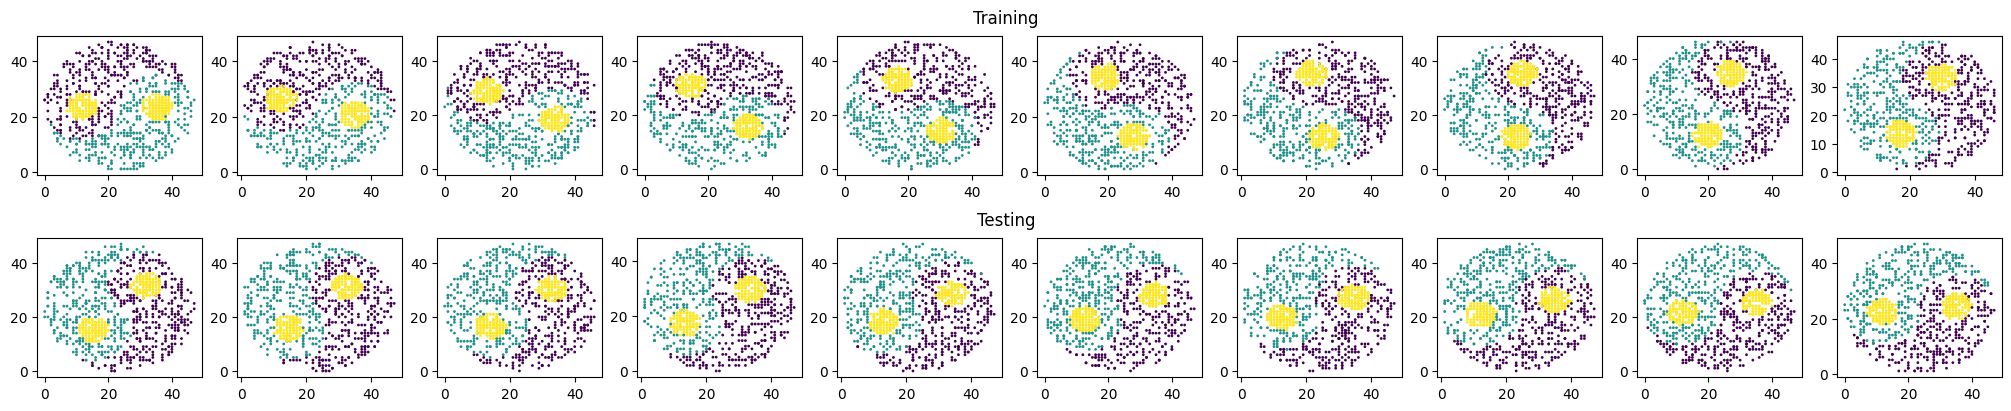

In [308]:
fig = plt.figure(figsize=(2 * data_config["meta_batch_size"], 4), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

for batch, subfig in zip([training_batch, testing_batch], subfigs):
    axs = subfig.subplots(1, data_config["meta_batch_size"])
    for i, (x, y) in enumerate(zip(*batch["train"])):
        try:
            ax = axs[i]
        except TypeError:
            ax = axs
        ax.scatter(
            x.argmax(1).squeeze()[:, 0], x.argmax(1).squeeze()[:, 1], c=y, cmap="viridis", s=1
        )
    subfig.suptitle("Training" if batch is training_batch else "Testing")

## Models

In [309]:
from eventprop.models import SNN, SpikeCELoss, FirstSpikeTime

In [310]:
model_config = {
    "model_type": "eventprop",
    "snn": {
        "T": data_config["T"],
        "dt": data_config["dt"],
        "tau_m": 20e-3,
        "tau_s": 5e-3,
    },
    "weights": {
        "init_mode": "kaiming_both",
        "scale_0_mu": 5,
        "scale_0_sigma": 3.5,
        "scale_1_mu": 5,
        "scale_1_sigma": 0.5,
        "n_hid": 120,
        "resolve_silent": False,
        "dropout": 0.0,
    },
    # "device": (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")),
    "device": torch.device("cpu"),
}

n_ins = {"mnist": 784, "ying_yang": 5 if data_config["encoding"] == "latency" else 4}
n_outs = {"mnist": 10, "ying_yang": 3}

In [311]:
training_config = {
    "num_epochs": 20,
    "loss": "ce_temporal",
    "alpha": 3e-3,
    "xi": 0.5,
    "beta": 6.4,
    "n_tests": 3,
    "exclude_equal": False,
    "do_train": True,
    "do_test": False,
}

## Inner Loop Optim
optim_config = {
    "lr": 5e-3,
    "weight_decay": 0.0,
    "optimizer": "adam",
    "gamma": 0.95,
}

maml_config = {
    "num_shots": None,
    "n_samples_test": 1000,
    "first_order": True,
    "meta-lr": 1e-2,
    "inner-lr": 1e-2,
    "learn_step_size": False,
    "meta-gamma": 0.95,
}

default_config = {
    "data": data_config,
    "model": model_config,
    "training": training_config,
    "optim": optim_config,
    "maml": maml_config,
}
config = get_flat_dict_from_nested(default_config)
args = argparse.Namespace(**config)

In [312]:
dims = [n_ins[config["dataset"]]]
if config["n_hid"] is not None and isinstance(config["n_hid"], list):
    dims.extend(config["n_hid"])
elif isinstance(config["n_hid"], int):
    dims.append(config["n_hid"])
dims.append(n_outs[config["dataset"]])

model = SNN(dims, **config).to(config["device"])
init_params = OrderedDict(model.meta_named_parameters()).copy()
first_spk_fn = FirstSpikeTime.apply

SNN SCALE :  [[5, 3.5], [5, 0.5]]


## MAML

In [313]:
from copy import deepcopy

In [314]:
class MAML(object):

    def __init__(self, model, default_config) -> None:

        self.model = model
        self.default_config = default_config
        self.flat_config = get_flat_dict_from_nested(default_config)
        self.args = argparse.Namespace(**self.flat_config)

        self.meta_optimizer = torch.optim.Adam(
            model.parameters(), lr=config["meta-lr"], weight_decay=config["weight_decay"]
        )
        self.inner_loss_fn = SpikeCELoss(
            alpha=self.flat_config["alpha"],
            xi=self.flat_config["xi"],
            beta=self.flat_config["beta"],
        )
        self.first_spk_fn = FirstSpikeTime.apply

        self.outer_iter = 0
        self.total_outer_iter = data_config["n_tasks_per_split"]

    def adapt(self, meta_sample, use_tqdm=False):

        inputs, targets = meta_sample
        inputs, targets = inputs.to(self.args.device), targets.to(self.args.device)

        if self.inner_optimizer is None:
            inner_optimizer = torch.optim.Adam(
                dict(model.meta_named_parameters()).values(),
                lr=self.flat_config["inner-lr"],
                weight_decay=config["weight_decay"],
            )
        else:
            inner_optimizer = self.inner_optimizer

        if self.flat_config["num_shots"] is None:
            n_shots = inputs.size(0)

        if use_tqdm:
            pbar = trange(n_shots, desc="Adaptation: ")
        else:
            pbar = range(n_shots)

        # batch one
        for input, target, _ in zip(
            inputs,
            targets,
            pbar,
        ):
            out_spikes, recordings = model(input)
            loss = self.inner_loss_fn(out_spikes, target)[0]
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()

    def inner_test(self, meta_sample, params=None):

        inputs, targets = meta_sample
        inputs = inputs.transpose(0, 1).to(self.args.device).squeeze()
        out_spikes, recordings = model(inputs, params=params)
        first_spikes = self.first_spk_fn(out_spikes)
        acc = (first_spikes.argmin(-1) == targets).float().mean()
        loss = self.inner_loss_fn(out_spikes, targets)[0]
        return acc, loss, recordings

    def get_outer_loss(self, meta_batch, train=False, use_tqdm=False):

        meta_losses = {"pre": [], "post": []}
        meta_accs = {"pre": [], "post": []}

        outer_loss = 0

        adapted_params = {}
        n_tasks = len(meta_batch["train"][0])
        if use_tqdm:
            pbar = trange(n_tasks, desc="Task: ")
        else:
            pbar = range(n_tasks)

        for task, (*train_meta_sample, _) in enumerate(zip(*meta_batch["train"], pbar)):

            current_weights = deepcopy(self.model.state_dict())

            # test before adapt
            test_meta_sample = [s[task] for s in meta_batch["test"]]
            pre_acc, pre_loss, _ = self.inner_test(test_meta_sample, params=current_weights)
            pre_acc = pre_acc.detach().cpu().numpy()
            meta_accs["pre"].append(pre_acc)
            meta_losses["pre"].append(pre_loss)

            # adapt
            self.adapt(train_meta_sample)
            candidate_weights = self.model.state_dict()

            post_acc, post_loss, _ = self.inner_test(test_meta_sample, params=candidate_weights)
            post_acc = post_acc.detach().cpu().numpy()
            meta_accs["post"].append(post_acc)
            meta_losses["post"].append(post_loss)
            outer_loss += post_loss

            alpha = self.flat_config["meta-lr"] * (1 - self.outer_iter / self.total_outer_iter)

            if train:
                updated_params = {
                    candidate: (
                        current_weights[candidate]
                        + alpha * (candidate_weights[candidate] - current_weights[candidate])
                    )
                    for candidate in candidate_weights
                }
                self.model.load_state_dict(updated_params)
                self.outer_iter += 1
            else:
                self.model.load_state_dict(current_weights)

            if use_tqdm:
                pbar.set_description(f"Task: {task}, Pre: {pre_acc:.2f}, Post: {post_acc:.2f}")

        return outer_loss, {
            "meta_accs": meta_accs,
            "meta_losses": meta_losses,
            "params": adapted_params,
        }

In [ ]:
raise KeyboardInterrupt

KeyboardInterrupt: 

### Finding the joint-training baseline (training on all rotations at once)

In [321]:
model = SNN(dims, **config).to(config["device"])
inner_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
maml_trainer = MAML(model, default_config)
maml_trainer.inner_optimizer = inner_optimizer

SNN SCALE :  [[5, 3.5], [5, 0.5]]


In [316]:
batch_size = 512
inputs = (
    training_batch["train"][0].permute(2, 3, 4, 0, 1).flatten(start_dim=-2).permute(-1, 0, 1, 2)
)
random_idxs = torch.randperm(inputs.shape[0])
targets = training_batch["train"][1].flatten()
inputs, targets = inputs[random_idxs], targets[random_idxs]


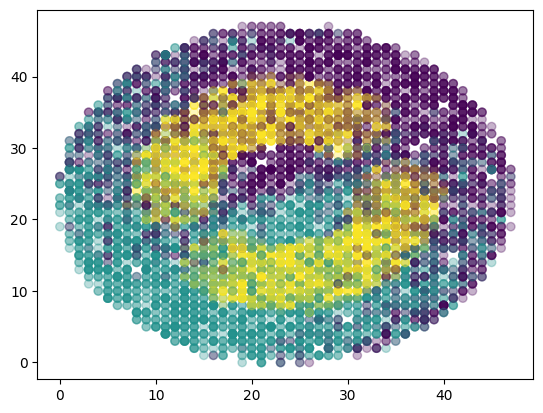

In [317]:
plt.scatter(inputs.argmax(1)[:, 0, 0], inputs.argmax(1)[:, 0, 1], c=targets[:], alpha=.3)

In [318]:
inputs, targets = inputs.split(batch_size), targets.split(batch_size)
for input, target, _ in zip(inputs, targets, trange(len(inputs))):
    maml_trainer.adapt((input, target))

  0%|          | 0/20 [00:00<?, ?it/s]

In [319]:
test_accs = []
inputs = (
    training_batch["test"][0].permute(2, 3, 4, 0, 1).flatten(start_dim=-2).permute(-1, 0, 1, 2)
)
targets = training_batch["test"][1].flatten()
inputs, targets = inputs.split(batch_size), targets.split(batch_size)
for input, target, _ in zip(inputs, targets, trange(len(inputs))):
    acc, *_ = maml_trainer.inner_test((input, target))
    test_accs.append(acc)
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [320]:
np.mean(test_accs)

0.44818473

### Making sure we can overfit on one subtask

In [84]:
inputs, targets = training_batch["test"]
inputs = inputs[0].to(config["device"])
targets = targets[0].to(config["device"])

acc, loss, recs = maml_trainer.inner_test((inputs, targets))
print(f"Pre Adaptation Accuracy: {acc}")

Pre Adaptation Accuracy: 0.5120000243186951


In [82]:
inputs, targets = training_batch["train"]
inputs = inputs[0]
targets = targets[0].to(config["device"])
new_params = maml_trainer.adapt((inputs, targets), use_tqdm=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
inputs, targets = training_batch["test"]
inputs = inputs[0].to(config["device"])
targets = targets[0].to(config["device"])

acc, loss, recs = maml_trainer.inner_test((inputs, targets), new_params)
print(f"Post Adaptation Accuracy: {acc}")

Post Adaptation Accuracy: 0.5120000243186951


## Outer Loss

In [169]:
train_accs = {
    "pre": [],
    "post": [],
}

In [170]:
for training_batch, batch_idx in zip(meta_train_dataloader, trange(20)):
    outer_loss, results = maml_trainer.get_outer_loss(training_batch, use_tqdm=False, train=True)
    train_accs["pre"].append([results["meta_accs"]["pre"]])
    train_accs["post"].append([results["meta_accs"]["post"]])

  0%|          | 0/20 [00:00<?, ?it/s]

In [171]:
train_accs = {n: np.concatenate(accs) for n, accs in train_accs.items()}

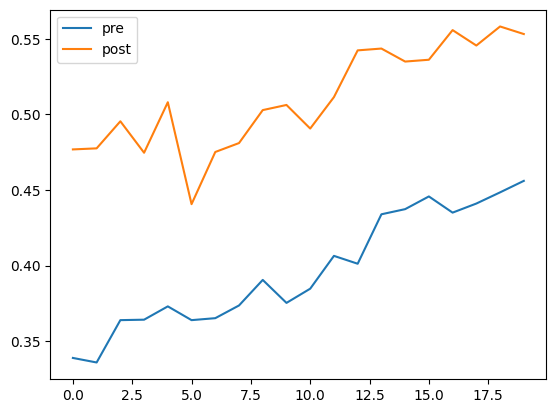

In [172]:
plt.plot(train_accs["pre"].mean(-1), label="pre")
plt.plot(train_accs["post"].mean(-1), label="post")
plt.legend()

In [186]:
(
    training_batch["train"][1].float().mean(0)[None, :] == training_batch["train"][1].float()
).float().mean()

tensor(0.0424)

In [21]:
import torchviz

In [22]:
torchviz.make_dot(outer_loss, dict(model.named_parameters())).render("maml_loss")

'maml_loss.pdf'